C:\Users\sidhs\AppData\Local\Temp\ipykernel_20904\864159944.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data = data.asfreq('T')  # Ensure data has a regular time frequency


Initial Stationarity Check:
ADF Statistic: -3.823036815515399
p-value: 0.002680219661272057
The time series is stationary.

Stationarity Check after Log Transformation:
ADF Statistic: -3.8586413303663156
p-value: 0.0023612108028642754
The time series is stationary.


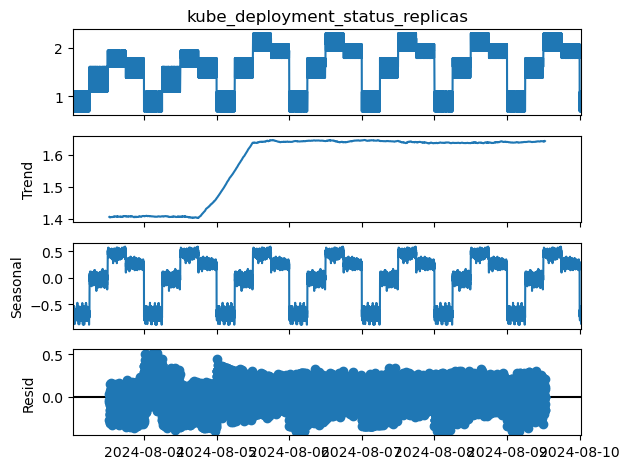

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import TimeSeriesSplit

# Load the dataset
data = pd.read_csv('/kaggle/input/prometheus-metrics-dataset/autoscaler_metrics.csv', parse_dates=['timestamp'], index_col='timestamp')

# Resample the data to ensure a consistent frequency
data = data.asfreq(freq="30min")

# Prepare the data for Prophet
df = pd.DataFrame({'ds': data.index, 'y': data['kube_deployment_status_replicas']})

# Handling missing values by forward filling
df['y'] = df['y'].fillna(method='ffill')

# Initialize Prophet model with custom settings
model = Prophet(
    yearly_seasonality=False,  # Adjust based on dataset's needs
    weekly_seasonality=True,   # Include weekly seasonality
    daily_seasonality=True,    # Include daily seasonality
    changepoint_prior_scale=0.2,  # Increased flexibility for changepoints
    seasonality_mode='additive'   # Test additive vs multiplicative
)

# Fit the model to the data
model.fit(df)

with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Forecasting the future values
future = model.make_future_dataframe(periods=48, freq='30min')  # Forecasting for the next 24 hours
forecast = model.predict(future)

forecast['yhat'] = forecast['yhat'].round()

# Plotting the forecast
plt.figure(figsize=(14, 7))
fig = model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

# Extract the forecasted values
forecasted_values = forecast[['ds', 'yhat']].set_index('ds')

# Plotting the forecast against the actual data
plt.figure(figsize=(14, 7))
plt.plot(df['ds'], df['y'], label='Actual')
plt.plot(forecasted_values.index, forecasted_values['yhat'], label='Forecast', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Replicas Count')
plt.title('Actual vs Forecasted')
plt.legend()
plt.grid(True)
plt.show()

# Time-Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []

for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]
    
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.1,  # Adjusted for flexibility
        seasonality_mode='multiplicative'   # Adjust based on data
    )
    model.fit(train)
    
    # Predicting on the test set
    test_future = model.make_future_dataframe(periods=len(test), freq='30min')
    test_forecast = model.predict(test_future)
    test_forecast = test_forecast[-len(test):]  # Slice the forecast to match the test set length
    
    mse = mean_squared_error(test['y'], test_forecast['yhat'])
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)

print(f'Cross-Validated RMSE: {np.mean(rmse_scores)}')

# Forecasting future values
future_forecast = model.predict(future[-48:])
future_forecast['yhat'] = future_forecast['yhat'].round()

# Plotting the future forecast with connected lines
plt.figure(figsize=(14, 7))
plt.plot(df.index[-48:], df['y'][-48:], label='Last Observations')
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Future Forecast', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Replicas Count')
plt.title('Last Observations vs Future Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Plot forecast components
plt.figure(figsize=(14, 7))
fig2 = model.plot_components(forecast)
plt.suptitle('Forecast Components')
plt.show()

# Plot forecast uncertainty intervals
plt.figure(figsize=(14, 7))
plt.plot(forecast['ds'], forecast['yhat_upper'], linestyle='--', color='grey', alpha=0.5, label='Uncertainty Interval')
plt.plot(forecast['ds'], forecast['yhat_lower'], linestyle='--', color='grey', alpha=0.5)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='grey', alpha=0.2)
plt.xlabel('Timestamp')
plt.ylabel('Replicas Count')
plt.title('Forecast with Uncertainty Intervals')
plt.legend()
plt.grid(True)
plt.show()
